In [1]:
from growing_instability_lib import *

Using TensorFlow backend.


In [2]:
sample_sub = pd.read_csv('../data/sampleSubmission.csv')
topics = sorted(set(sample_sub.columns.difference(['id'])))

topic2actual = {}
for i in sample_sub.columns:
    if 'id' == i:
        continue
    topic2actual[i] = segment(i)
    
target_columns = sorted(topics)
len(topics)

160

In [3]:
%%time
wvec_trainingX = pd.read_hdf('training_data_wv_fs_no_stopwords.hdf', 'wvec_trainingX')
fvec_trainingX = pd.read_hdf('training_data_wv_fs_no_stopwords.hdf', 'fvec_trainingX')
word2idx_trainingX = pd.read_hdf('training_data_wv_fs_no_stopwords.hdf', 'word2idx_trainingX')
_word2idx = pd.read_hdf('training_data_wv_fs_no_stopwords.hdf', '_word2idx')
trainingY = pd.read_hdf('training_data_wv_fs_no_stopwords.hdf', 'trainingY')

CPU times: user 9.34 s, sys: 1.68 s, total: 11 s
Wall time: 11 s


In [4]:
%%time
word2ind = _word2idx.to_dict()

ind2word = {i: j + 1 for i, j in word2ind.items()}  # Remove the increment if data is fixed.
word2ind = {j: i for i, j in ind2word.items()}

ind2class = dict(enumerate(topics))
class2ind = {j: i for i, j in ind2class.items()}

num_samples = trainingY.shape[0]

training_X = word2idx_trainingX.head(num_samples)

training_Y = pd.DataFrame(zip(*np.where(trainingY.head(num_samples) == 1)), columns=['iloc', 'topics'])
training_WV = wvec_trainingX.head(num_samples)
training_FS = fvec_trainingX.head(num_samples)

training_Y = training_Y.groupby('iloc')['topics'].apply(list)
training_Y.index = trainingY.head(num_samples).index

# indices = sorted(training_Y.index.copy())
indices = sorted(training_Y.index[training_Y.index.str.contains('^201[0-9]')])
np.random.shuffle(indices)
indices = pd.Index(indices)

training_X = training_X.ix[indices]
training_WV = training_WV.ix[indices]
training_FS = training_FS.ix[indices]
training_Y = training_Y.ix[indices]

dataset = zip(training_X, training_Y)

CPU times: user 20.3 s, sys: 68 ms, total: 20.4 s
Wall time: 20.3 s


In [5]:
# def generate_lstm_batch_dataset(dataset, word2ind, class2ind, max_len, batch_size=1000, shuffle=True):
#     if shuffle:
#         np.random.shuffle(dataset)

#     num_docs = len(dataset)
#     num_words = len(word2ind) + 1
#     num_class = len(class2ind)

#     for s in xrange(0, num_docs, batch_size):
#         x_batch = np.zeros([batch_size, max_len, num_words])
#         y_batch = np.zeros([batch_size, num_class])

#         for ix, (features, target) in enumerate(dataset[s:s + batch_size]):
#             # print features
#             for idx, feat in enumerate(features):
#                 if idx >= max_len:
#                     break

#                 # print feat, ind2word[feat]
#                 x_batch[ix, idx, feat] = 1

#             if not isinstance(target, list):
#                 target = [target]
                
#             for tg in target:
#                 y_batch[ix, tg] = 1

#         yield x_batch[:ix + 1, :, :], y_batch[:ix + 1, :]


# def infinite_lstm_dataset_generator(dataset, word2ind, class2ind, max_len, batch_size=100):
#     while 1:
#         for b in generate_lstm_batch_dataset(dataset, word2ind, class2ind, max_len, batch_size):
#             yield b

# # lens = []
# # for i in dataset:
# #     lens.append(len(i[0]))
# # pd.Series(lens).quantile(0.999)
# # Use the above to estimate the acceptable timeseries dimension.
# LSTM_TIMESERIES = 100
# id_lstm_gen = infinite_lstm_dataset_generator(dataset, word2ind, class2ind, max_len=LSTM_TIMESERIES, batch_size=10)



In [6]:
from keras.preprocessing import sequence


def build_target(y, size):
    e = np.zeros(size)
    e[y] = 1
    return e

maxlen = 500
x_train = sequence.pad_sequences(training_X, maxlen=maxlen)
y_train = np.vstack(training_Y.map(lambda x: build_target(x, len(topics))))
wv_train = np.vstack(training_WV)
fs_train = np.vstack(training_FS)

In [7]:
# # Setup model
# model_lstm = keras.models.Sequential()
# model_lstm.add(keras.layers.Embedding(len(word2ind) + 1, 256))
# # model_lstm.add(keras.layers.LSTM(32, return_sequences=False, input_shape=(None, len(word2ind) + 1)))
# # model_lstm.add(keras.layers.Dropout(0.2))
# model_lstm.add(keras.layers.LSTM(16, return_sequences=False))
# model_lstm.add(keras.layers.Dense(128))
# model_lstm.add(keras.layers.Activation('relu'))
# model_lstm.add(keras.layers.Dropout(0.2))
# model_lstm.add(keras.layers.Dense(len(class2ind)))
# model_lstm.add(keras.layers.Activation('sigmoid'))
# model_lstm.compile(
#     loss='binary_crossentropy',
#     optimizer='adam',
#     metrics=['accuracy']
# )

# # for i in range(6):
# #     model_lstm.fit_generator(id_lstm_gen, steps_per_epoch=len(dataset), epochs=1)

In [8]:
from keras.layers import Input, Embedding, LSTM, Dense
from keras.models import Model

# Headline input: meant to receive sequences of 100 integers, between 1 and 10000.
# Note that we can name any layer by passing it a "name" argument.
main_input = Input(shape=(maxlen,), dtype='int32', name='main_input')

# This embedding layer will encode the input sequence
# into a sequence of dense 512-dimensional vectors.
x = Embedding(output_dim=300, input_dim=len(word2ind) + 1, input_length=maxlen)(main_input)

# A LSTM will transform the vector sequence into a single vector,
# containing information about the entire sequence
lstm_out = LSTM(32)(x)

auxiliary_output = Dense(len(class2ind), activation='sigmoid', name='aux_output')(lstm_out)


wv_input = Input(shape=(300,), name='wv_input')
fs_input = Input(shape=(300,), name='fs_input')

x = keras.layers.concatenate([lstm_out, wv_input, fs_input])

# We stack a deep densely-connected network on top
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)

# And finally we add the main logistic regression layer
main_output = Dense(len(class2ind), activation='sigmoid', name='main_output')(x)

model = Model(inputs=[main_input, wv_input, fs_input], outputs=[main_output, auxiliary_output])

In [9]:
import tensorflow as K


def f1_micro(y_true, y_pred):
    TP = K.metrics.true_positives(y_true, K.round(y_pred))
    FP = K.metrics.false_positives(y_true, K.round(y_pred))
    FN = K.metrics.false_negatives(y_true, K.round(y_pred))
    
    p = K.reduce_sum(TP) / (K.reduce_sum(TP) + K.reduce_sum(FP))
    r = K.reduce_sum(TP) / (K.reduce_sum(TP) + K.reduce_sum(FN))
    
    return (2.0 * p * r) / (p + r)

In [10]:
model.compile(optimizer='adam',
              loss={'main_output': 'categorical_crossentropy', 'aux_output': 'categorical_crossentropy'},
              loss_weights={'main_output': 1., 'aux_output': 0.2}, metrics=['accuracy', f1_micro])

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
main_input (InputLayer)          (None, 500)           0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 500, 300)      105478200                                    
____________________________________________________________________________________________________
lstm_1 (LSTM)                    (None, 32)            42624                                        
____________________________________________________________________________________________________
wv_input (InputLayer)            (None, 300)           0                                            
___________________________________________________________________________________________

In [11]:
# from keras.callbacks import EarlyStopping
# early_stopping = EarlyStopping(monitor='val_loss', patience=2)
# model.fit(X, y, validation_split=0.2, callbacks=[early_stopping])

In [12]:
# import keras.backend as K
# K.clear_session()

In [13]:
# model.train_on_batch(
#     {'main_input': x_train[:10], 'wv_input': np.vstack(training_WV)[:10], 'fs_input': np.vstack(training_FS)[:10]},
#     {'main_output': y_train[:10], 'aux_output': y_train[:10]}
# )

In [17]:
%%time
# And trained it via:
batch_size = 770
model.fit(
    {'main_input': x_train, 'wv_input': wv_train, 'fs_input': fs_train},
    {'main_output': y_train, 'aux_output': y_train},
    epochs=1, batch_size=batch_size,   # 500
    validation_split=0.2
)

Train on 75784 samples, validate on 18947 samples
Epoch 1/1
75784/75784 [==============================] - 67s - loss: 8.0963 - main_output_loss: 6.6978 - aux_output_loss: 6.9926 - main_output_acc: 0.0821 - main_output_f1_micro: 0.0443 - aux_output_acc: 0.0473 - aux_output_f1_micro: 0.0452 - val_loss: 7.7324 - val_main_output_loss: 6.4343 - val_aux_output_loss: 6.4903 - val_main_output_acc: 0.0845 - val_main_output_f1_micro: 0.0583 - val_aux_output_acc: 0.0336 - val_aux_output_f1_micro: 0.0562
CPU times: user 1min 22s, sys: 7.99 s, total: 1min 30s
Wall time: 1min 7s


In [18]:
%%time
model_name = 'models/lstm-word2vec-fasttext_2010-2014-data_categorical-crossentropy.model'
for i in xrange(0, 100):
    hist = model.fit(
        {'main_input': x_train, 'wv_input': wv_train, 'fs_input': fs_train},
        {'main_output': y_train, 'aux_output': y_train},
        epochs=1, batch_size=batch_size,   # 500
        validation_split=0.2
    )

    model.save(model_name.format(i))
    print('Done with epoch: {}'.format(i + 1))
    with open('lstm-word2vec-fasttext.epoch.csv', 'a') as fl:
        fl.write(model_name + '\n')
        fl.write('Epoch {}\n'.format(i + 1))
        fl.write('{}\n'.format(datetime.now()))
        fl.write('\n'.join(['{}: {}'.format(k, v[0]) for k, v in hist.history.items()]))
        fl.write('\n\n')
    print

Train on 75784 samples, validate on 18947 samples
Epoch 1/1
75784/75784 [==============================] - 67s - loss: 7.6298 - main_output_loss: 6.3417 - aux_output_loss: 6.4409 - main_output_acc: 0.0821 - main_output_f1_micro: 0.0646 - aux_output_acc: 0.0552 - aux_output_f1_micro: 0.0614 - val_loss: 7.4471 - val_main_output_loss: 6.1622 - val_aux_output_loss: 6.4246 - val_main_output_acc: 0.0845 - val_main_output_f1_micro: 0.0701 - val_aux_output_acc: 0.0731 - val_aux_output_f1_micro: 0.0652
Done with epoch: 1

Train on 75784 samples, validate on 18947 samples
Epoch 1/1
75784/75784 [==============================] - 67s - loss: 7.0397 - main_output_loss: 5.7620 - aux_output_loss: 6.3881 - main_output_acc: 0.0839 - main_output_f1_micro: 0.0757 - aux_output_acc: 0.0689 - aux_output_f1_micro: 0.0680 - val_loss: 6.5862 - val_main_output_loss: 5.3025 - val_aux_output_loss: 6.4185 - val_main_output_acc: 0.1317 - val_main_output_f1_micro: 0.0816 - val_aux_output_acc: 0.0548 - val_aux_output

75784/75784 [==============================] - 67s - loss: 2.5041 - main_output_loss: 1.7505 - aux_output_loss: 3.7683 - main_output_acc: 0.7504 - main_output_f1_micro: 0.0818 - aux_output_acc: 0.4886 - aux_output_f1_micro: 0.0847 - val_loss: 4.8283 - val_main_output_loss: 3.8787 - val_aux_output_loss: 4.7481 - val_main_output_acc: 0.5297 - val_main_output_f1_micro: 0.0821 - val_aux_output_acc: 0.3207 - val_aux_output_f1_micro: 0.0846
Done with epoch: 16

Train on 75784 samples, validate on 18947 samples
Epoch 1/1
75784/75784 [==============================] - 68s - loss: 2.4111 - main_output_loss: 1.6884 - aux_output_loss: 3.6138 - main_output_acc: 0.7594 - main_output_f1_micro: 0.0826 - aux_output_acc: 0.5190 - aux_output_f1_micro: 0.0845 - val_loss: 4.8208 - val_main_output_loss: 3.8841 - val_aux_output_loss: 4.6835 - val_main_output_acc: 0.5193 - val_main_output_f1_micro: 0.0831 - val_aux_output_acc: 0.3328 - val_aux_output_f1_micro: 0.0844
Done with epoch: 17

Train on 75784 sampl

75784/75784 [==============================] - 67s - loss: 1.7407 - main_output_loss: 1.2816 - aux_output_loss: 2.2954 - main_output_acc: 0.7926 - main_output_f1_micro: 0.1061 - aux_output_acc: 0.7253 - aux_output_f1_micro: 0.0819 - val_loss: 5.1883 - val_main_output_loss: 4.3382 - val_aux_output_loss: 4.2504 - val_main_output_acc: 0.5346 - val_main_output_f1_micro: 0.1072 - val_aux_output_acc: 0.4317 - val_aux_output_f1_micro: 0.0818
Done with epoch: 31

Train on 75784 samples, validate on 18947 samples
Epoch 1/1
75784/75784 [==============================] - 67s - loss: 1.7162 - main_output_loss: 1.2682 - aux_output_loss: 2.2402 - main_output_acc: 0.7934 - main_output_f1_micro: 0.1084 - aux_output_acc: 0.7312 - aux_output_f1_micro: 0.0817 - val_loss: 5.2081 - val_main_output_loss: 4.3595 - val_aux_output_loss: 4.2432 - val_main_output_acc: 0.5360 - val_main_output_f1_micro: 0.1095 - val_aux_output_acc: 0.4330 - val_aux_output_f1_micro: 0.0816
Done with epoch: 32

Train on 75784 sampl

75784/75784 [==============================] - 67s - loss: 1.4804 - main_output_loss: 1.1324 - aux_output_loss: 1.7401 - main_output_acc: 0.7979 - main_output_f1_micro: 0.1467 - aux_output_acc: 0.7730 - aux_output_f1_micro: 0.0800 - val_loss: 5.5056 - val_main_output_loss: 4.6593 - val_aux_output_loss: 4.2317 - val_main_output_acc: 0.5241 - val_main_output_f1_micro: 0.1482 - val_aux_output_acc: 0.4543 - val_aux_output_f1_micro: 0.0800
Done with epoch: 46

Train on 75784 samples, validate on 18947 samples
Epoch 1/1
75784/75784 [==============================] - 67s - loss: 1.4674 - main_output_loss: 1.1243 - aux_output_loss: 1.7155 - main_output_acc: 0.7985 - main_output_f1_micro: 0.1498 - aux_output_acc: 0.7758 - aux_output_f1_micro: 0.0800 - val_loss: 5.5001 - val_main_output_loss: 4.6534 - val_aux_output_loss: 4.2335 - val_main_output_acc: 0.5238 - val_main_output_f1_micro: 0.1513 - val_aux_output_acc: 0.4560 - val_aux_output_f1_micro: 0.0799
Done with epoch: 47

Train on 75784 sampl

75784/75784 [==============================] - 66s - loss: 1.3446 - main_output_loss: 1.0526 - aux_output_loss: 1.4598 - main_output_acc: 0.7994 - main_output_f1_micro: 0.1975 - aux_output_acc: 0.7860 - aux_output_f1_micro: 0.0805 - val_loss: 5.6995 - val_main_output_loss: 4.8386 - val_aux_output_loss: 4.3042 - val_main_output_acc: 0.5298 - val_main_output_f1_micro: 0.1994 - val_aux_output_acc: 0.4675 - val_aux_output_f1_micro: 0.0805
Done with epoch: 61

Train on 75784 samples, validate on 18947 samples
Epoch 1/1
75784/75784 [==============================] - 66s - loss: 1.3410 - main_output_loss: 1.0519 - aux_output_loss: 1.4456 - main_output_acc: 0.8011 - main_output_f1_micro: 0.2013 - aux_output_acc: 0.7889 - aux_output_f1_micro: 0.0806 - val_loss: 5.7144 - val_main_output_loss: 4.8492 - val_aux_output_loss: 4.3260 - val_main_output_acc: 0.5135 - val_main_output_f1_micro: 0.2031 - val_aux_output_acc: 0.4606 - val_aux_output_f1_micro: 0.0807
Done with epoch: 62

Train on 75784 sampl

75784/75784 [==============================] - 66s - loss: 1.2652 - main_output_loss: 1.0066 - aux_output_loss: 1.2932 - main_output_acc: 0.7995 - main_output_f1_micro: 0.2568 - aux_output_acc: 0.7926 - aux_output_f1_micro: 0.0836 - val_loss: 5.9594 - val_main_output_loss: 5.0695 - val_aux_output_loss: 4.4493 - val_main_output_acc: 0.5234 - val_main_output_f1_micro: 0.2588 - val_aux_output_acc: 0.4697 - val_aux_output_f1_micro: 0.0838
Done with epoch: 76

Train on 75784 samples, validate on 18947 samples
Epoch 1/1
75784/75784 [==============================] - 66s - loss: 1.2624 - main_output_loss: 1.0056 - aux_output_loss: 1.2842 - main_output_acc: 0.8017 - main_output_f1_micro: 0.2610 - aux_output_acc: 0.7925 - aux_output_f1_micro: 0.0839 - val_loss: 6.0023 - val_main_output_loss: 5.1075 - val_aux_output_loss: 4.4740 - val_main_output_acc: 0.5168 - val_main_output_f1_micro: 0.2630 - val_aux_output_acc: 0.4639 - val_aux_output_f1_micro: 0.0841
Done with epoch: 77

Train on 75784 sampl

75784/75784 [==============================] - 66s - loss: 1.2146 - main_output_loss: 0.9771 - aux_output_loss: 1.1875 - main_output_acc: 0.8013 - main_output_f1_micro: 0.3205 - aux_output_acc: 0.7952 - aux_output_f1_micro: 0.0891 - val_loss: 6.2020 - val_main_output_loss: 5.2797 - val_aux_output_loss: 4.6114 - val_main_output_acc: 0.5176 - val_main_output_f1_micro: 0.3226 - val_aux_output_acc: 0.4713 - val_aux_output_f1_micro: 0.0893
Done with epoch: 91

Train on 75784 samples, validate on 18947 samples
Epoch 1/1
75784/75784 [==============================] - 66s - loss: 1.2175 - main_output_loss: 0.9812 - aux_output_loss: 1.1815 - main_output_acc: 0.8001 - main_output_f1_micro: 0.3247 - aux_output_acc: 0.7969 - aux_output_f1_micro: 0.0895 - val_loss: 6.2246 - val_main_output_loss: 5.2991 - val_aux_output_loss: 4.6277 - val_main_output_acc: 0.5130 - val_main_output_f1_micro: 0.3268 - val_aux_output_acc: 0.4626 - val_aux_output_f1_micro: 0.0897
Done with epoch: 92

Train on 75784 sampl

In [22]:
%%time
for j in xrange(i, i + 100):
    hist = model.fit(
        {'main_input': x_train, 'wv_input': wv_train, 'fs_input': fs_train},
        {'main_output': y_train, 'aux_output': y_train},
        epochs=1, batch_size=700,   # 500
        validation_split=0.2
    )

    model.save(model_name.format(i))
    print('Done with epoch: {}'.format(j + 1))
    with open('lstm-word2vec-fasttext.epoch.csv', 'a') as fl:
        fl.write(model_name + '\n')
        fl.write('Epoch {}\n'.format(j + 1))
        fl.write('{}\n'.format(datetime.now()))
        fl.write('\n'.join(['{}: {}'.format(k, v[0]) for k, v in hist.history.items()]))
        fl.write('\n\n')
    print

Train on 75784 samples, validate on 18947 samples
Epoch 1/1
75784/75784 [==============================] - 73s - loss: 1.1619 - main_output_loss: 0.9456 - aux_output_loss: 1.0813 - main_output_acc: 0.8021 - main_output_f1_micro: 0.4188 - aux_output_acc: 0.7969 - aux_output_f1_micro: 0.1016 - val_loss: 6.6308 - val_main_output_loss: 5.6509 - val_aux_output_loss: 4.8994 - val_main_output_acc: 0.5088 - val_main_output_f1_micro: 0.4206 - val_aux_output_acc: 0.4642 - val_aux_output_f1_micro: 0.1019
Done with epoch: 114

Train on 75784 samples, validate on 18947 samples
Epoch 1/1
75784/75784 [==============================] - 72s - loss: 1.1711 - main_output_loss: 0.9539 - aux_output_loss: 1.0859 - main_output_acc: 0.8007 - main_output_f1_micro: 0.4226 - aux_output_acc: 0.7980 - aux_output_f1_micro: 0.1022 - val_loss: 6.6731 - val_main_output_loss: 5.6870 - val_aux_output_loss: 4.9304 - val_main_output_acc: 0.5059 - val_main_output_f1_micro: 0.4244 - val_aux_output_acc: 0.4639 - val_aux_outp

75784/75784 [==============================] - 72s - loss: 1.1350 - main_output_loss: 0.9273 - aux_output_loss: 1.0383 - main_output_acc: 0.7984 - main_output_f1_micro: 0.4716 - aux_output_acc: 0.7968 - aux_output_f1_micro: 0.1122 - val_loss: 6.9412 - val_main_output_loss: 5.9254 - val_aux_output_loss: 5.0790 - val_main_output_acc: 0.5050 - val_main_output_f1_micro: 0.4733 - val_aux_output_acc: 0.4617 - val_aux_output_f1_micro: 0.1125
Done with epoch: 129

Train on 75784 samples, validate on 18947 samples
Epoch 1/1
75784/75784 [==============================] - 73s - loss: 1.1374 - main_output_loss: 0.9300 - aux_output_loss: 1.0368 - main_output_acc: 0.8025 - main_output_f1_micro: 0.4749 - aux_output_acc: 0.7988 - aux_output_f1_micro: 0.1129 - val_loss: 6.9895 - val_main_output_loss: 5.9751 - val_aux_output_loss: 5.0722 - val_main_output_acc: 0.5102 - val_main_output_f1_micro: 0.4765 - val_aux_output_acc: 0.4670 - val_aux_output_f1_micro: 0.1133
Done with epoch: 130

Train on 75784 sam

75784/75784 [==============================] - 73s - loss: 1.1205 - main_output_loss: 0.9185 - aux_output_loss: 1.0097 - main_output_acc: 0.8013 - main_output_f1_micro: 0.5171 - aux_output_acc: 0.7983 - aux_output_f1_micro: 0.1240 - val_loss: 7.2375 - val_main_output_loss: 6.1914 - val_aux_output_loss: 5.2304 - val_main_output_acc: 0.5022 - val_main_output_f1_micro: 0.5185 - val_aux_output_acc: 0.4600 - val_aux_output_f1_micro: 0.1245
Done with epoch: 144

Train on 75784 samples, validate on 18947 samples
Epoch 1/1
75784/75784 [==============================] - 73s - loss: 1.1192 - main_output_loss: 0.9174 - aux_output_loss: 1.0091 - main_output_acc: 0.8021 - main_output_f1_micro: 0.5199 - aux_output_acc: 0.8001 - aux_output_f1_micro: 0.1249 - val_loss: 7.3255 - val_main_output_loss: 6.2785 - val_aux_output_loss: 5.2349 - val_main_output_acc: 0.5029 - val_main_output_f1_micro: 0.5213 - val_aux_output_acc: 0.4579 - val_aux_output_f1_micro: 0.1253
Done with epoch: 145

Train on 75784 sam

75784/75784 [==============================] - 73s - loss: 1.1014 - main_output_loss: 0.9047 - aux_output_loss: 0.9831 - main_output_acc: 0.8005 - main_output_f1_micro: 0.5558 - aux_output_acc: 0.7995 - aux_output_f1_micro: 0.1376 - val_loss: 7.6402 - val_main_output_loss: 6.5601 - val_aux_output_loss: 5.4005 - val_main_output_acc: 0.4987 - val_main_output_f1_micro: 0.5569 - val_aux_output_acc: 0.4535 - val_aux_output_f1_micro: 0.1381
Done with epoch: 159

Train on 75784 samples, validate on 18947 samples
Epoch 1/1
75784/75784 [==============================] - 73s - loss: 1.1020 - main_output_loss: 0.9055 - aux_output_loss: 0.9824 - main_output_acc: 0.8012 - main_output_f1_micro: 0.5581 - aux_output_acc: 0.8014 - aux_output_f1_micro: 0.1385 - val_loss: 7.5804 - val_main_output_loss: 6.5011 - val_aux_output_loss: 5.3962 - val_main_output_acc: 0.4955 - val_main_output_f1_micro: 0.5593 - val_aux_output_acc: 0.4618 - val_aux_output_f1_micro: 0.1390
Done with epoch: 160

Train on 75784 sam

75784/75784 [==============================] - 73s - loss: 1.0921 - main_output_loss: 0.8988 - aux_output_loss: 0.9665 - main_output_acc: 0.8002 - main_output_f1_micro: 0.5885 - aux_output_acc: 0.7985 - aux_output_f1_micro: 0.1525 - val_loss: 7.8747 - val_main_output_loss: 6.7745 - val_aux_output_loss: 5.5010 - val_main_output_acc: 0.4975 - val_main_output_f1_micro: 0.5895 - val_aux_output_acc: 0.4592 - val_aux_output_f1_micro: 0.1530
Done with epoch: 174

Train on 75784 samples, validate on 18947 samples
Epoch 1/1
75784/75784 [==============================] - 73s - loss: 1.0908 - main_output_loss: 0.8977 - aux_output_loss: 0.9656 - main_output_acc: 0.7963 - main_output_f1_micro: 0.5905 - aux_output_acc: 0.7996 - aux_output_f1_micro: 0.1535 - val_loss: 7.9730 - val_main_output_loss: 6.8717 - val_aux_output_loss: 5.5064 - val_main_output_acc: 0.4948 - val_main_output_f1_micro: 0.5915 - val_aux_output_acc: 0.4579 - val_aux_output_f1_micro: 0.1540
Done with epoch: 175

Train on 75784 sam

75784/75784 [==============================] - 73s - loss: 1.0779 - main_output_loss: 0.8882 - aux_output_loss: 0.9487 - main_output_acc: 0.8017 - main_output_f1_micro: 0.6163 - aux_output_acc: 0.8016 - aux_output_f1_micro: 0.1688 - val_loss: 8.2770 - val_main_output_loss: 7.1505 - val_aux_output_loss: 5.6326 - val_main_output_acc: 0.4907 - val_main_output_f1_micro: 0.6172 - val_aux_output_acc: 0.4548 - val_aux_output_f1_micro: 0.1693
Done with epoch: 189

Train on 75784 samples, validate on 18947 samples
Epoch 1/1
75784/75784 [==============================] - 73s - loss: 1.0766 - main_output_loss: 0.8873 - aux_output_loss: 0.9465 - main_output_acc: 0.7999 - main_output_f1_micro: 0.6181 - aux_output_acc: 0.7999 - aux_output_f1_micro: 0.1699 - val_loss: 8.2267 - val_main_output_loss: 7.0991 - val_aux_output_loss: 5.6384 - val_main_output_acc: 0.4911 - val_main_output_f1_micro: 0.6189 - val_aux_output_acc: 0.4534 - val_aux_output_f1_micro: 0.1704
Done with epoch: 190

Train on 75784 sam

75784/75784 [==============================] - 73s - loss: 1.0736 - main_output_loss: 0.8856 - aux_output_loss: 0.9402 - main_output_acc: 0.7985 - main_output_f1_micro: 0.6403 - aux_output_acc: 0.8016 - aux_output_f1_micro: 0.1861 - val_loss: 8.5849 - val_main_output_loss: 7.4386 - val_aux_output_loss: 5.7319 - val_main_output_acc: 0.4927 - val_main_output_f1_micro: 0.6410 - val_aux_output_acc: 0.4562 - val_aux_output_f1_micro: 0.1867
Done with epoch: 204

Train on 75784 samples, validate on 18947 samples
Epoch 1/1
75784/75784 [==============================] - 73s - loss: 1.0718 - main_output_loss: 0.8838 - aux_output_loss: 0.9401 - main_output_acc: 0.7962 - main_output_f1_micro: 0.6417 - aux_output_acc: 0.8002 - aux_output_f1_micro: 0.1874 - val_loss: 8.5390 - val_main_output_loss: 7.3912 - val_aux_output_loss: 5.7387 - val_main_output_acc: 0.4972 - val_main_output_f1_micro: 0.6425 - val_aux_output_acc: 0.4559 - val_aux_output_f1_micro: 0.1879
Done with epoch: 205

Train on 75784 sam

In [21]:
i = j

In [23]:
g = model.predict({'main_input': x_train[:100], 'wv_input': wv_train[:100], 'fs_input': fs_train[:100]})

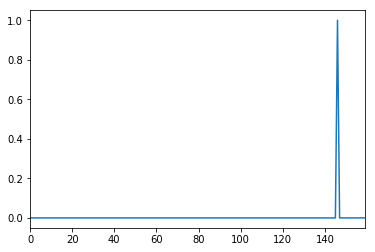

In [24]:
%matplotlib inline
ix = 29
pd.Series(g[0][ix]).plot()

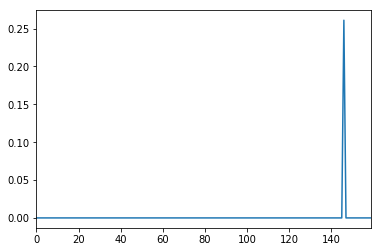

In [25]:
pd.Series(g[1][ix]).plot()

In [26]:
thresh = 0.5
np.where(y_train[ix] == 1), np.where(g[0][ix] > thresh), np.where(g[1][ix] > thresh)

((array([146]),), (array([146]),), (array([], dtype=int64),))

In [29]:
wvmodel = Word2Vec.load('corpus/train_body_data-with_labels_False-retain_special_chars_False.with_test_data.csv.w2v.model')

In [30]:
fsmodel = fasttext.load_model('corpus/train_body_data-with_labels_False-retain_special_chars_False.with_test_data.csv.fasttext.model.bin')

In [31]:
def transform_fasttext(tokens, stopwords=[]):
    global fsmodel
    # This requires fsmodel to be present in the namespace.
    fs_feature_vec = tokens.map(
        lambda x: [w for w in x.split() if (w not in stopwords)]
    ).map(lambda x: np.array([fsmodel[w] for w in x]).mean(axis=0) if len(x) > 0 else np.nan)

    return fs_feature_vec


def transform_unsupervised_sentiment_neuron(tokens, stopwords=[]):
    # This requires fsmodel to be present in the namespace.
    
    usn_feature_vec = usnmodel.transform(tokens)

    # usn_feature_vec = tokens.map(
    #     lambda x: [w for w in x.split() if (w not in stopwords)]
    # ).map(lambda x: np.array([usnmodel[w] for w in x]).mean(axis=0) if len(x) > 0 else np.nan)

    return usn_feature_vec


def transform_word2vec(tokens, stopwords=[]):
    global wvmodel
    # This requires wvmodel to be present in the namespace.
    wv_feature_vec = tokens.map(
        lambda x: [w for w in x.split() if (w not in stopwords and w in wvmodel.wv.vocab)]
    ).map(lambda x: np.array([wvmodel[w] for w in x]).mean(axis=0) if len(x) > 0 else np.nan)

    return wv_feature_vec


def parallel_generate_word_vectors(samp, transformer, stopwords, batch, num_proc):
    with Parallel(n_jobs=num_proc) as parallel:
        dataset = []
        is_break = False
        i = 0

        while not is_break:
            payload = []

            for j in xrange(num_proc):
                t_df = samp[(i + j) * batch: (i + 1 + j) * batch]

                if t_df.empty:
                    is_break = True
                    continue

                payload.append(
                    delayed(transformer)(
                        t_df, stopwords
                    )
                )

            print('Current batch in main thread: {}'.format((i + j) * batch))

            if payload:
                results = parallel(payload)
                dataset.extend(results)
                i += num_proc

    return pd.concat(dataset)


In [32]:
def get_classes(pred, scale_param=0.75, min_thresh=0.05, thresh = 0.5):
#     mx = pred.mean() + 3 * pred.std()
    return np.where(pred > thresh)[0]  

In [33]:
def word2idx_transform(word, _word2idx):
    return _word2idx.get(word, 0)


In [34]:
def extract_features_for(df, min_batch=2000, stopwords=[], num_proc=7):
    df_tokens = transform_text(df)
    
    batch = min(df_tokens.shape[0] / num_proc, min_batch)

    print('Computing fs features...')
    fvec = parallel_generate_word_vectors(df_tokens, transform_fasttext, stopwords=stopwords, batch=batch, num_proc=num_proc)

    print('Computing wv features...')
    wvec = parallel_generate_word_vectors(df_tokens, transform_word2vec, stopwords=stopwords, batch=batch, num_proc=num_proc)

    print('Mapping word indices...')
    word_indices = df_tokens.map(lambda x: [word2idx_transform(i, _word2idx) for i in x.split()])
    
    return word_indices, wvec, fvec

In [36]:
with open('../data/TestData.json') as fl:
    data = json.load(fl)
    test_df = pd.DataFrame(data['TestData']).T
    del(data)

In [37]:
%%time
test_word_indices,test_wvec, test_fvec = extract_features_for(test_df)

Computing fs features...
Current batch in main thread: 6498
Current batch in main thread: 14079
Computing wv features...
Current batch in main thread: 6498
Current batch in main thread: 14079
Mapping word indices...
CPU times: user 44.6 s, sys: 10.6 s, total: 55.2 s
Wall time: 2min 57s


In [38]:
assert(np.all(test_wvec[test_wvec.isnull()].index == test_fvec[test_fvec.isnull()].index))
test_null_index = test_wvec[test_wvec.isnull()].index.union(test_fvec[test_fvec.isnull()].index)

In [39]:
test_null_index

Index([u'TestData_02543', u'TestData_05012', u'TestData_05830'], dtype='object')

Index([u'TestData_02543', u'TestData_05012', u'TestData_05830'], dtype='object')

In [40]:
%%time
maxlen = 500

valid_test_index = test_word_indices.index.difference(test_null_index)
x_test = sequence.pad_sequences(test_word_indices.ix[valid_test_index], maxlen=maxlen)
wv_test = np.vstack(test_wvec.ix[valid_test_index])
fs_test = np.vstack(test_fvec.ix[valid_test_index])

CPU times: user 328 ms, sys: 12 ms, total: 340 ms
Wall time: 341 ms


In [41]:
test_probas = model.predict({'main_input': x_test, 'wv_input': wv_test, 'fs_input': fs_test}, batch_size=batch_size)

In [42]:
main_test_probas, aux_test_probas = test_probas

In [43]:
skip_index = [int(s.split('_')[1]) - 1 for s in test_null_index]  # Subtract 1 since test index starts at 1 while enumerate starts at 0
skip_index

[2542, 5011, 5829]

In [44]:
main_test_probas.shape, test_df.shape

((7578, 160), (7581, 3))

In [88]:
%%time
adjust_index = 0
# valid_test_feature_vec found below!
test_values = np.zeros([test_df.shape[0], len(topics)])
for ix, pred in enumerate(main_test_probas):
    if ix in skip_index:
        test_values[ix] = np.nan
        # Increment adjust index so that we have the correct index for other samples
        adjust_index += 1
        continue

    for v in get_classes(pred, thresh=0.01):
        test_values[ix + adjust_index][v] = 1

test_sub_df = pd.DataFrame(test_values, columns=sorted(topics), index=test_df.index)

q = test_sub_df.sum(axis=1)
assert(len(q[q.isnull()].index.difference(test_null_index)) == 0)

test_sub_df = test_sub_df.fillna(0)

# for i in test_feature_vec[test_feature_vec.isnull()].index:
#     test_sub_df.ix[i] = np.zeros(len(topics))

CPU times: user 36 ms, sys: 4 ms, total: 40 ms
Wall time: 36.3 ms


In [89]:
test_sub_df.ix[test_null_index].sum(axis=1)

TestData_02543    0.0
TestData_05012    0.0
TestData_05830    0.0
dtype: float64

In [90]:
test_sub_df.sum().sum()

16382.0

In [96]:
test_sub_df.astype(int).reset_index().rename(
    columns={'index': 'id'}
).sort_values('id').to_csv(
    'lstm_300-word2vec_300-fasttext_300-maxlen_500-dense_64_64_64-cat_cross-epoch_210-batch_size_750-val_main_output_f1_micro_0.6536-main_output_f1_micro_0.6529-main_output_loss_0.8810-data_2010_2014-thresh_0.01.csv', 
    index=False
)

In [182]:
e = test_sub_df['zikavirus']
e[e==1]

Series([], Name: zikavirus, dtype: float64)

In [53]:
top_submission = pd.read_csv('basic_nn_submission_0.649_accuracy_multi_class.csv')

In [54]:
wrong_index_lstm_sub = pd.read_csv('lstm.2014b_training_700_maxlen_64cell_100epochs_0.0025_threshold.csv')

In [55]:
some_sub = pd.read_csv('basic_nn_submission_full_training_data_0.9958_validation_accuracy_binary_crossentropy.csv')
some_sub.set_index('id').sum().sum()

34952

In [106]:
top_submission.set_index('id').ix[q[q == 0].index].sum(axis=1)

TestData_00011     0
TestData_00012     0
TestData_00015     0
TestData_00027     3
TestData_00029     0
TestData_00038     1
TestData_00042     5
TestData_00053     4
TestData_00056     1
TestData_00060     1
TestData_00066     0
TestData_00085     0
TestData_00087     1
TestData_00090     0
TestData_00092     0
TestData_00107     3
TestData_00111     0
TestData_00114     0
TestData_00115     1
TestData_00118     0
TestData_00119     0
TestData_00121     0
TestData_00123     0
TestData_00125     0
TestData_00127     0
TestData_00128     1
TestData_00139     1
TestData_00140     1
TestData_00144     0
TestData_00147     2
                  ..
TestData_07445     0
TestData_07456     3
TestData_07461     1
TestData_07462     4
TestData_07465     0
TestData_07468     0
TestData_07471     1
TestData_07475     0
TestData_07486    10
TestData_07495     1
TestData_07509     0
TestData_07514     3
TestData_07515     1
TestData_07523     0
TestData_07533     2
TestData_07534     2
TestData_0754

In [132]:
top_submission.set_index('id') == test_sub_df

,activism,afghanistan,aid,algerianhostagecrisis,alqaida,alshabaab,antiwar,arabandmiddleeastprotests,armstrade,australianguncontrol,...,unitednations,usguncontrol,values,warcrimes,warreporting,weaponstechnology,womeninbusiness,woolwichattack,worldmigration,zikavirus
id,,,,,,,,,,,,,,,,,,,,,
TestData_00001,True,True,True,True,True,True,True,True,True,True,...,True,False,True,True,True,True,True,True,True,True
TestData_00002,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
TestData_00003,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
TestData_00004,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
TestData_00005,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
TestData_00006,True,True,True,True,True,True,True,True,True,True,...,False,True,True,True,True,True,True,True,True,True
TestData_00007,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
TestData_00008,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
TestData_00009,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


In [133]:
test_sub_df

,activism,afghanistan,aid,algerianhostagecrisis,alqaida,alshabaab,antiwar,arabandmiddleeastprotests,armstrade,australianguncontrol,...,unitednations,usguncontrol,values,warcrimes,warreporting,weaponstechnology,womeninbusiness,woolwichattack,worldmigration,zikavirus
TestData_00001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TestData_00002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TestData_00003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TestData_00004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TestData_00005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TestData_00006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TestData_00007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TestData_00008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TestData_00009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TestData_00010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [91]:
q = test_sub_df.sum(axis=1)
q[q==0].shape

(1222,)

In [92]:
q.describe()

count    7581.000000
mean        2.160929
std         1.739411
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        13.000000
dtype: float64

In [157]:
q = trainingY.sum(axis=1)

In [158]:
q.describe()

count    236286.000000
mean          1.392787
std           0.762577
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          15.000000
dtype: float64

In [230]:
test_df.sample(5)

,bodyText,topics,webPublicationDate
TestData_02924,Thousands of refugees trying to make their way...,[],19-10-2015
TestData_03032,Barack Obama’s announcement on Friday that Ame...,[],31-10-2015
TestData_01921,"The home secretary, Theresa May, has refused t...",[],20-07-2015
TestData_01649,"On Sunday, it will be a year since James Rodrí...",[],26-06-2015
TestData_02618,"On Saturday night, the Cereal Killer Cafe – a ...",[],28-09-2015


In [93]:
test_ix = 'TestData_01921'

In [94]:
q = test_sub_df.ix[test_ix]
q[q>0]

isis     1.0
syria    1.0
Name: TestData_01921, dtype: float64

In [95]:
q = top_submission.set_index('id').ix[test_ix]
q[q>0]

iraq          1
isis          1
syria         1
terrorism     1
uksecurity    1
Name: TestData_01921, dtype: int64

In [71]:
q = some_sub.set_index('id').ix[test_ix]
q[q>0]

defence       1
iraq          1
isis          1
military      1
religion      1
syria         1
terrorism     1
uksecurity    1
Name: TestData_01921, dtype: int64

In [58]:
q = wrong_index_lstm_sub.set_index('id').ix[test_ix]
q[q>0]

britisharmy    1
judiciary      1
Name: TestData_01921, dtype: int64

In [ ]:
Counter-terrorism policy
 
Foreign policy
 
Defence policy
 
Islamic State
 
Syria
 
news

In [229]:
test_null_index

Index([u'TestData_02543', u'TestData_05012', u'TestData_05830'], dtype='object')

In [170]:
for i in topics:
    print i

activism
afghanistan
aid
algerianhostagecrisis
alqaida
alshabaab
antiwar
arabandmiddleeastprotests
armstrade
australianguncontrol
australiansecurityandcounterterrorism
bastilledaytruckattack
belgium
berlinchristmasmarketattack
bigdata
biometrics
bokoharam
bostonmarathonbombing
britisharmy
brusselsattacks
cameroon
carers
charliehebdoattack
chemicalweapons
clusterbombs
cobra
conflictanddevelopment
controversy
criminaljustice
cybercrime
cyberwar
darknet
dataprotection
debate
defence
deflation
drones
drugs
drugspolicy
drugstrade
earthquakes
ebola
economy
egypt
encryption
energy
espionage
ethics
europeanarrestwarrant
europeancourtofhumanrights
events
extradition
famine
farright
firefighters
forensicscience
france
francetrainattack
freedomofspeech
genevaconventions
germany
guncrime
hacking
hashtags
helicoptercrashes
humanitarianresponse
humanrights
humanrightsact
humantrafficking
immigration
india
indonesia
internallydisplacedpeople
internationalcourtofjustice
internationalcriminaljustice
in

In [263]:
cosine_similarity(wvmodel['zika'], np.vstack(test_wvec.dropna())).max()

/home/avsolatorio/ml-ai/local/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


0.3445929

In [259]:
cosine_similarity(fsmodel['zika'], np.vstack(test_fvec.dropna())).max()

/home/avsolatorio/ml-ai/local/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


0.38107796869050226

In [251]:
test_df.ix[4488 + 1]

bodyText              The World Health Organisation has convened an ...
topics                                                               []
webPublicationDate                                           28-01-2016
Name: TestData_04490, dtype: object

In [257]:
test_df.ix[6727 + 2]

bodyText              The United Nations security council has called...
topics                                                               []
webPublicationDate                                           17-09-2016
Name: TestData_06730, dtype: object

In [253]:
test_df.ix[359]

bodyText              We are deeply concerned that the counter-terro...
topics                                                               []
webPublicationDate                                           02-02-2015
Name: TestData_00360, dtype: object

In [270]:
q = test_sub_df.iloc[4488 + 1]
q[q > 0]

drugstrade    1.0
Name: TestData_04490, dtype: float64